In [1]:
from analysis_classes import *
import os

dataset_directory = "../csv_to_protobuf_bin/binary_logs/AWS_FXS/"

binary_datasets = os.listdir(dataset_directory)

# labels_ = "89"
binary_datasets_name_dict = {}

for i, name in enumerate(binary_datasets):
    # if labels_ in i:
    #     dtns_data.append(i)
    binary_datasets_name_dict[i] = name
print(binary_datasets_name_dict)
# round5 : 1 round - each round 3 minutes- 10 seconds wait- without clearing cache table and only using vm touch. Simple sender and reciever buffer size is 1 MB. - HDD osts
# * round7 : 2 round - each round 3 minutes- 10 seconds wait- clearing cache table and using vm touch as well. Simple sender and reciever buffer size is 1 MB. - HDD osts

# round8 : 1 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts
# * round9 : 2 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts
# round10 : 2 reound - each round 6 time 30 seconds - 10 seconds wait- with clearing cache and using vm touch as well. Simple sender and reciever buffer size is 1 MB.- SSD osts - No write congestion from other clients on sender used ost


{0: 'round10', 1: 'round6', 2: 'round1', 3: 'round9', 4: 'round5', 5: 'round2', 6: 'series11', 7: 'round7'}


In [2]:

print("Dataset in directory {} is \t{}".format(dataset_directory, len(binary_datasets_name_dict)))

# hdd_round7_dataset_name = binary_datasets_name_dict[6]
# hdd_round7_ta_obj = TransferAnalysis(dataset_directory + hdd_round7_dataset_name)
# hdd_round7_df = hdd_round7_ta_obj.df

ssd_round_9_dataset_name = binary_datasets_name_dict[6]
ssd_round_9_ta_obj = TransferAnalysis(dataset_directory + ssd_round_9_dataset_name)
ssd_round_9_df = ssd_round_9_ta_obj.df

chosen_dataset_name = ssd_round_9_dataset_name
dtns_df = ssd_round_9_df
print("Dataframe shape for dtns dataset {} is : {}".format(chosen_dataset_name, dtns_df.shape))
print(len(ssd_round_9_df.keys()))

Dataset in directory ../csv_to_protobuf_bin/binary_logs/AWS_FXS/ is 	8
Dataframe shape for dtns dataset series11 is : (8545, 117)
117


In [3]:
print(len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))))


81


In [6]:

# merge two sets of write congestions together
g_label = GroupedLabels(total_possible_labels=90)
print(len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))))
# dtns_df = g_label.grouped_write_cate(df=dtns_df)
dtns_df = g_label.grouped_levels_cate(df=dtns_df)
print(len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))))
# print (dtns_df["label_value"])

18
18


In [7]:
def train_test_split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.drop(df.columns[len(df.columns) - 1], axis=1)
    y = df[df.columns[len(df.columns) - 1]]
    # total_labels = len(dict(Counter(y)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [8]:
print(len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns) - 1]]))))
# print(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns)-1]])))
# a, b, c, d = train_test_split_df(dtns_df)

18


In [9]:
# Running a model with a data set default model is random forest
a_model = Model_Run()
x_dtns_train, x_dtns_test, y_dtns_train, y_dtns_test = train_test_split_df(dtns_df)
print("Accuracy of the model {} on dataset {} is".format(a_model.model_to_name[a_model.model_name], chosen_dataset_name),
    a_model.run_model(df=dtns_df))

rf_model = a_model.generate_with_all(x_dtns_train, y_dtns_train)


Accuracy of the model Random Forest on dataset series11 is 0.9912229373902867


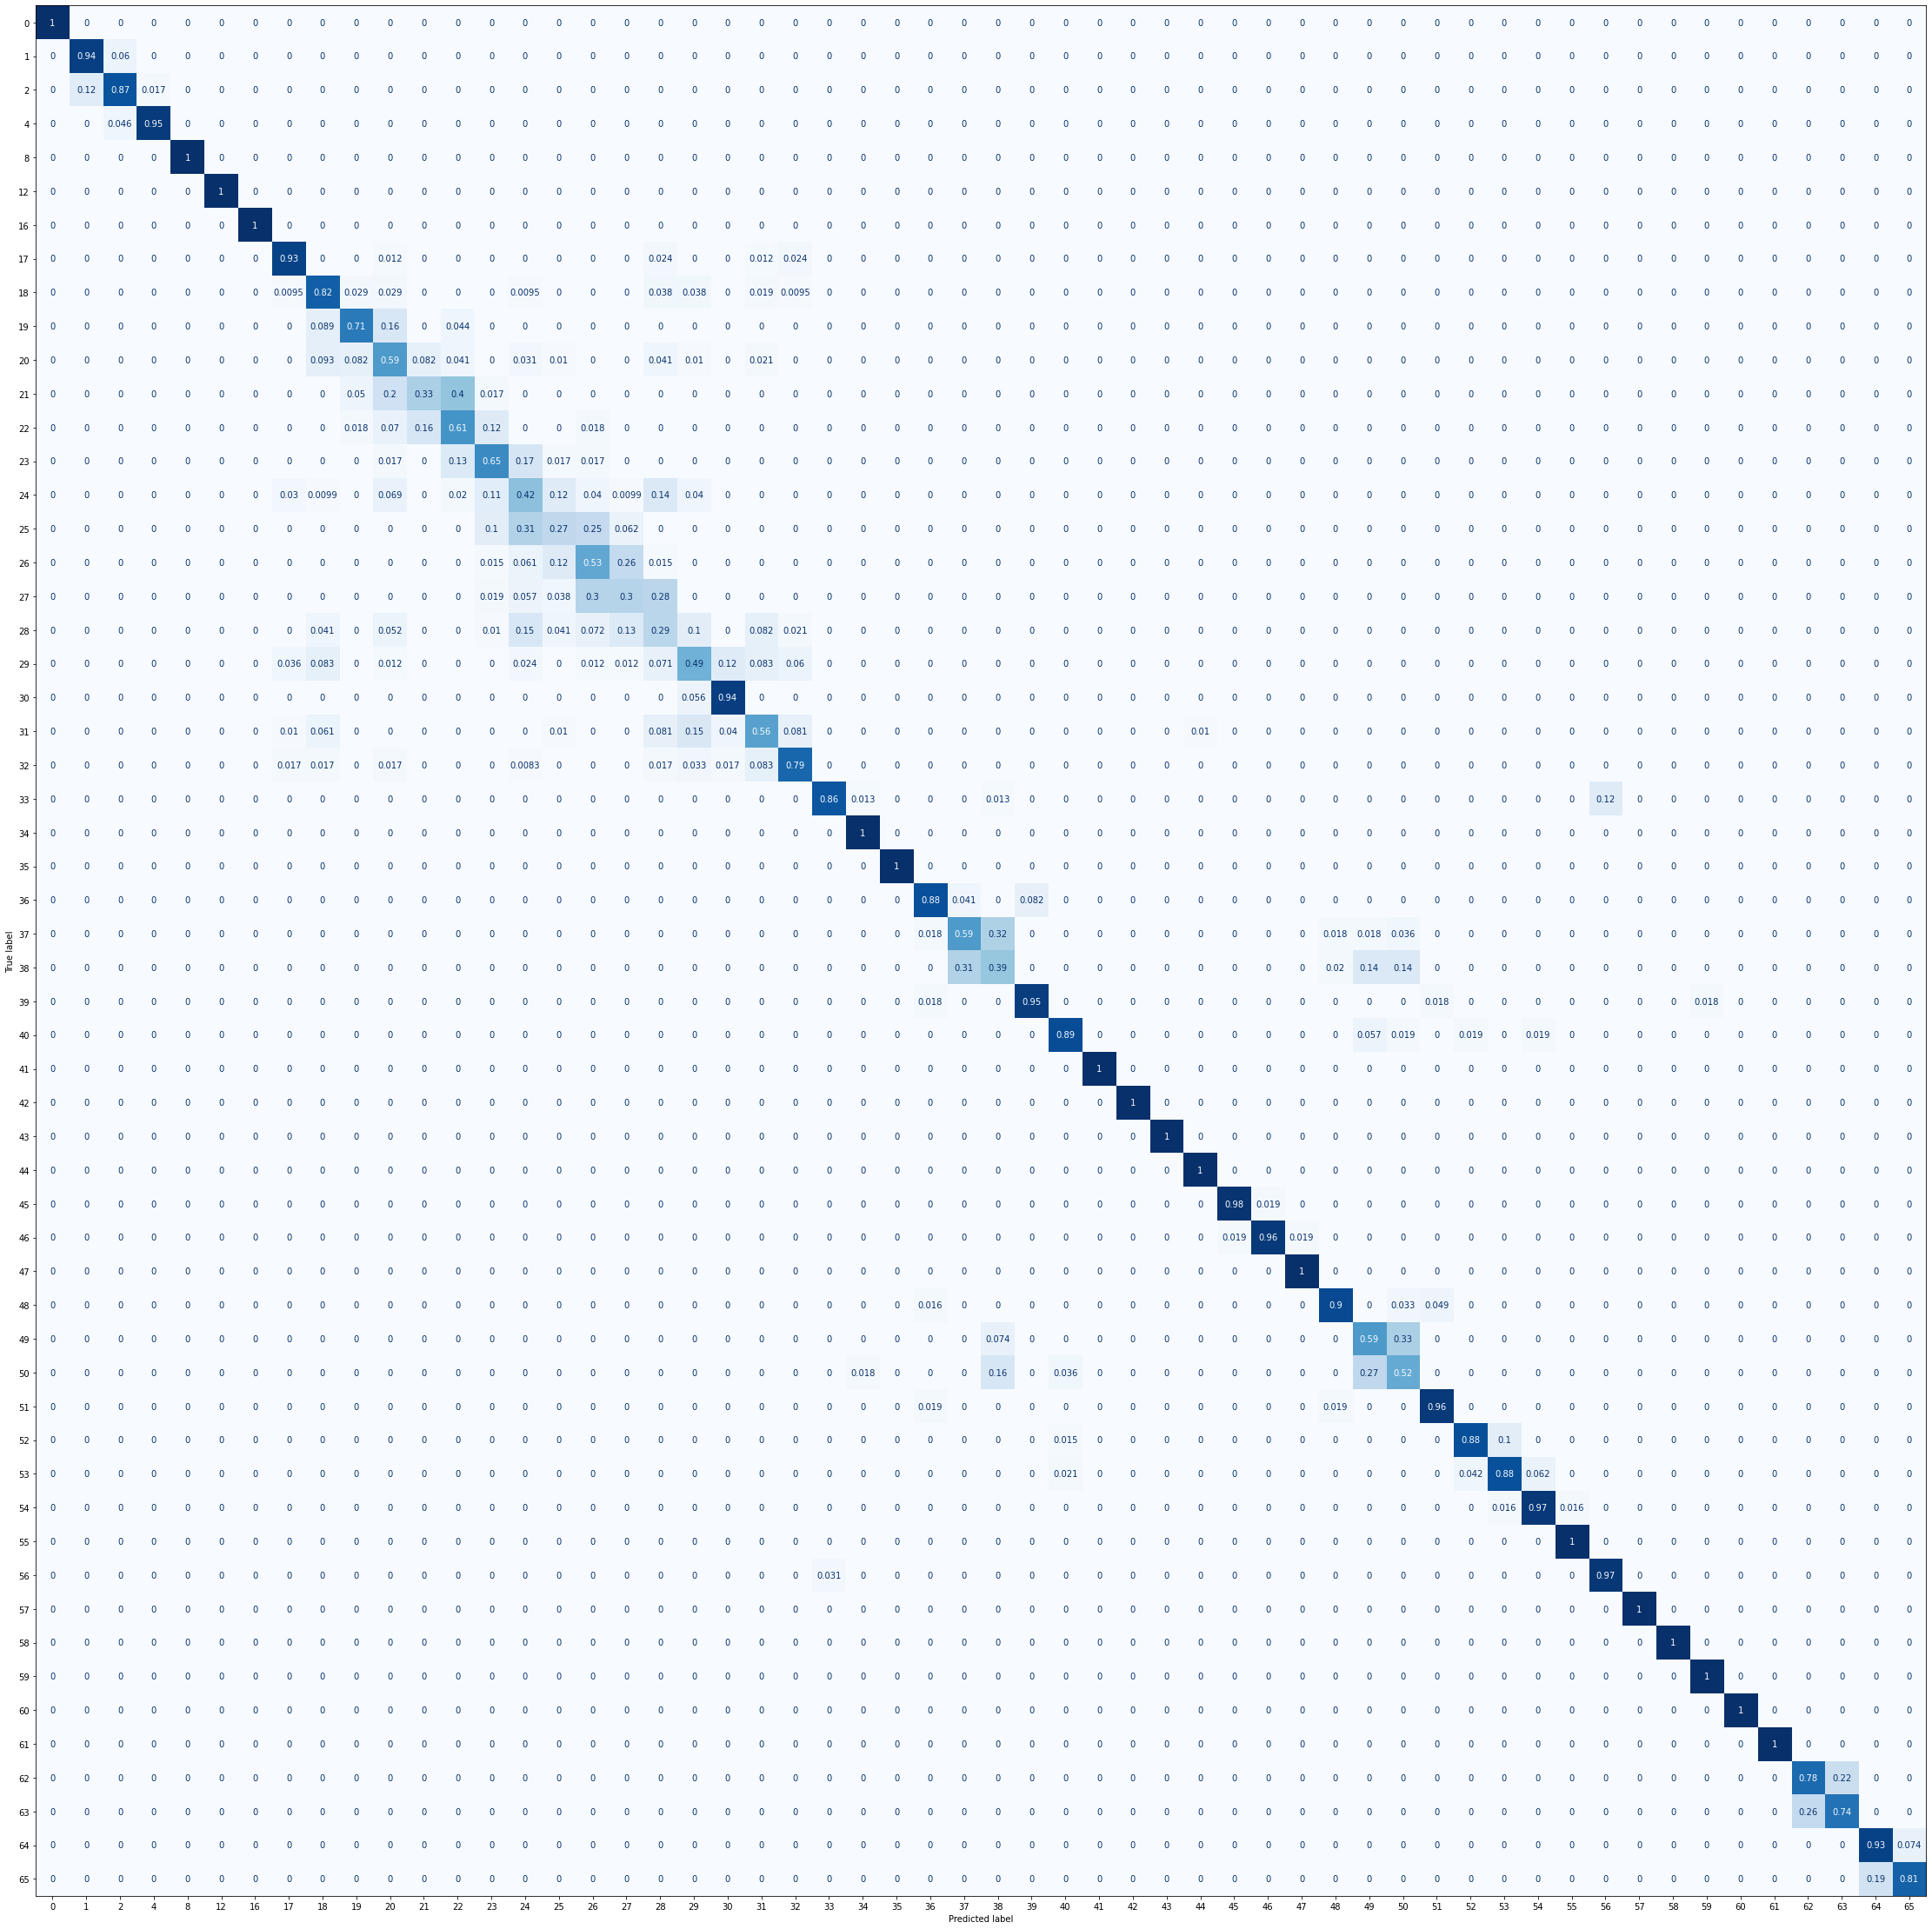

In [7]:
# creating confusion matrix for the chosen dataset and model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_predicted = rf_model.predict(x_dtns_test)

fig, ax = plt.subplots(figsize=(40, 40))
disp = ConfusionMatrixDisplay.from_predictions(y_dtns_test, y_predicted, labels=rf_model.classes_, normalize='true',
                                               cmap=plt.cm.Blues, ax=ax, colorbar=False)
fig.savefig('grouped_all_levels_dataset_{}_confusion_matrix.jpg'.format(chosen_dataset_name), dpi=100)


Elapsed time to compute the importances: 0.003 seconds
116


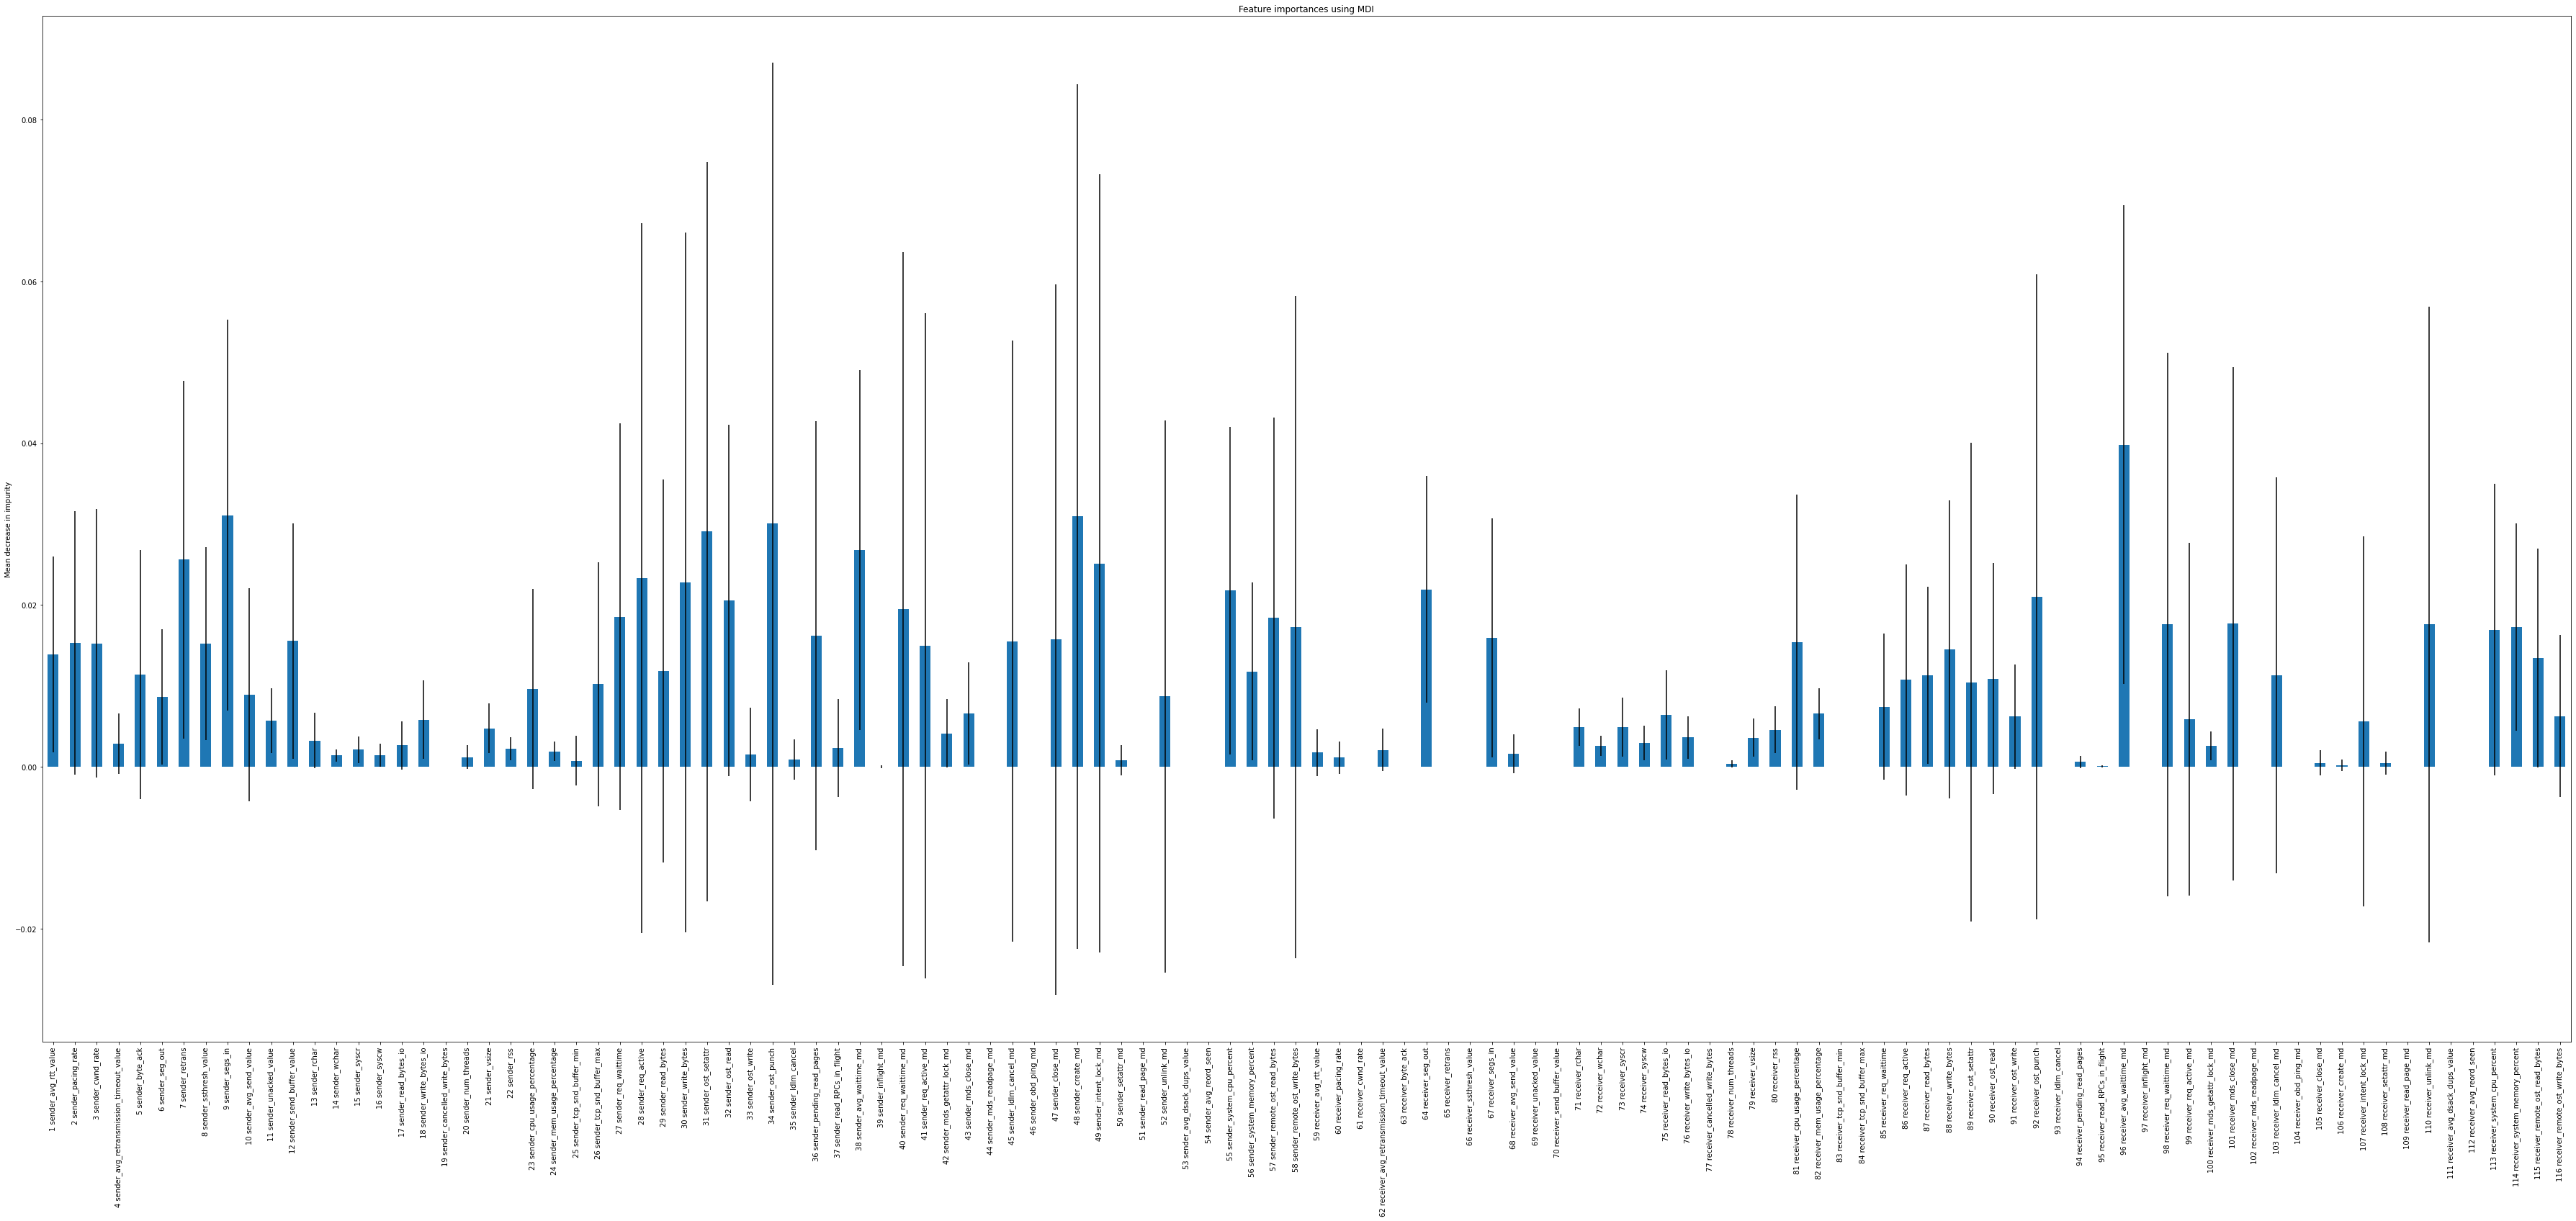

In [10]:
import time
import numpy as np
import pandas as pd

start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: " f"{elapsed_time:.3f} seconds")

feature_names = np.array([str(i + 1) + " " + str(j) for i, j in enumerate(dtns_df.columns[:-1])])
print(len(feature_names))
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(50, 25)
fig.savefig('new_grouped_all_levels_dataset_{}_feature_importance.jpeg'.format(chosen_dataset_name), dpi=100)
fig.tight_layout()

In [23]:

importances_copy = importances
keys = ssd_round_9_ta_obj.keys[:-1]
feature_names = np.array([i for i in dtns_df.columns[:-1]])

accuracy_list = np.array([])
feature_numbers = np.array([])
selected_features_name =  []
# len(importances) + 1
for n_max_value in range(1, len(importances) + 1):
    print(n_max_value)
    # Get indices of n max important features based on the importance array
    max_indices = np.argpartition(importances_copy, np.negative(n_max_value))[np.negative(n_max_value):]
    # print(max_indices)
    selected_key = np.concatenate((np.take(keys, max_indices), ssd_round_9_ta_obj.keys[-1:]))
    selected_features = np.take(feature_names, max_indices)
    temp_df = TransferAnalysis(dataset_directory + ssd_round_9_dataset_name, selected_key).df
    # grouped_temp_df = g_label.grouped_levels_cate(df=temp_df)
    grouped_temp_df = g_label.grouped_write_cate(df=temp_df)
    temp_model = Model_Run()
    x_dtns_train, x_dtns_test, y_dtns_train, y_dtns_test = train_test_split_df(temp_df)
    acc = temp_model.run_model(df=grouped_temp_df)
    accuracy_list = np.append(accuracy_list, np.round(acc * 100, 2))
    feature_numbers = np.append(feature_numbers, n_max_value)
    selected_features_name.append(selected_features)
    # print("Accuracy of {} on dataset {} with\t{} most important features is".format(
    #     temp_model.model_to_name[temp_model.model_name],
    #     ssd_round_9_dataset_name,
    #     n_max_value), acc)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [14]:

text=""
for i in range(len(feature_numbers)):
    names = ""
    for name in selected_features_name[i]:
        names += "{}, ".format(name)
    text += "{}:    {}\n".format('{0:0{1}}'.format(int(feature_numbers[i]), 2), names)
print(text)


01:    segs_in, 
02:    system_cpu_percent, segs_in, 
03:    byte_ack, system_cpu_percent, segs_in, 
04:    seg_out, system_cpu_percent, byte_ack, segs_in, 
05:    ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
06:    cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
07:    ost_read, cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
08:    send_buffer_value, ost_read, cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
09:    req_waittime, send_buffer_value, ost_read, cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
10:    avg_send_value, ost_read, send_buffer_value, req_waittime, cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
11:    req_active, avg_send_value, ost_read, send_buffer_value, req_waittime, cwnd_rate, ssthresh_value, seg_out, system_cpu_percent, byte_ack, segs_in, 
12:    avg_rtt_value, send_buffer_value, avg_send_value, req_

[43.515 55.085]


ValueError: x and y must have same first dimension, but have shapes (58,) and (54,)

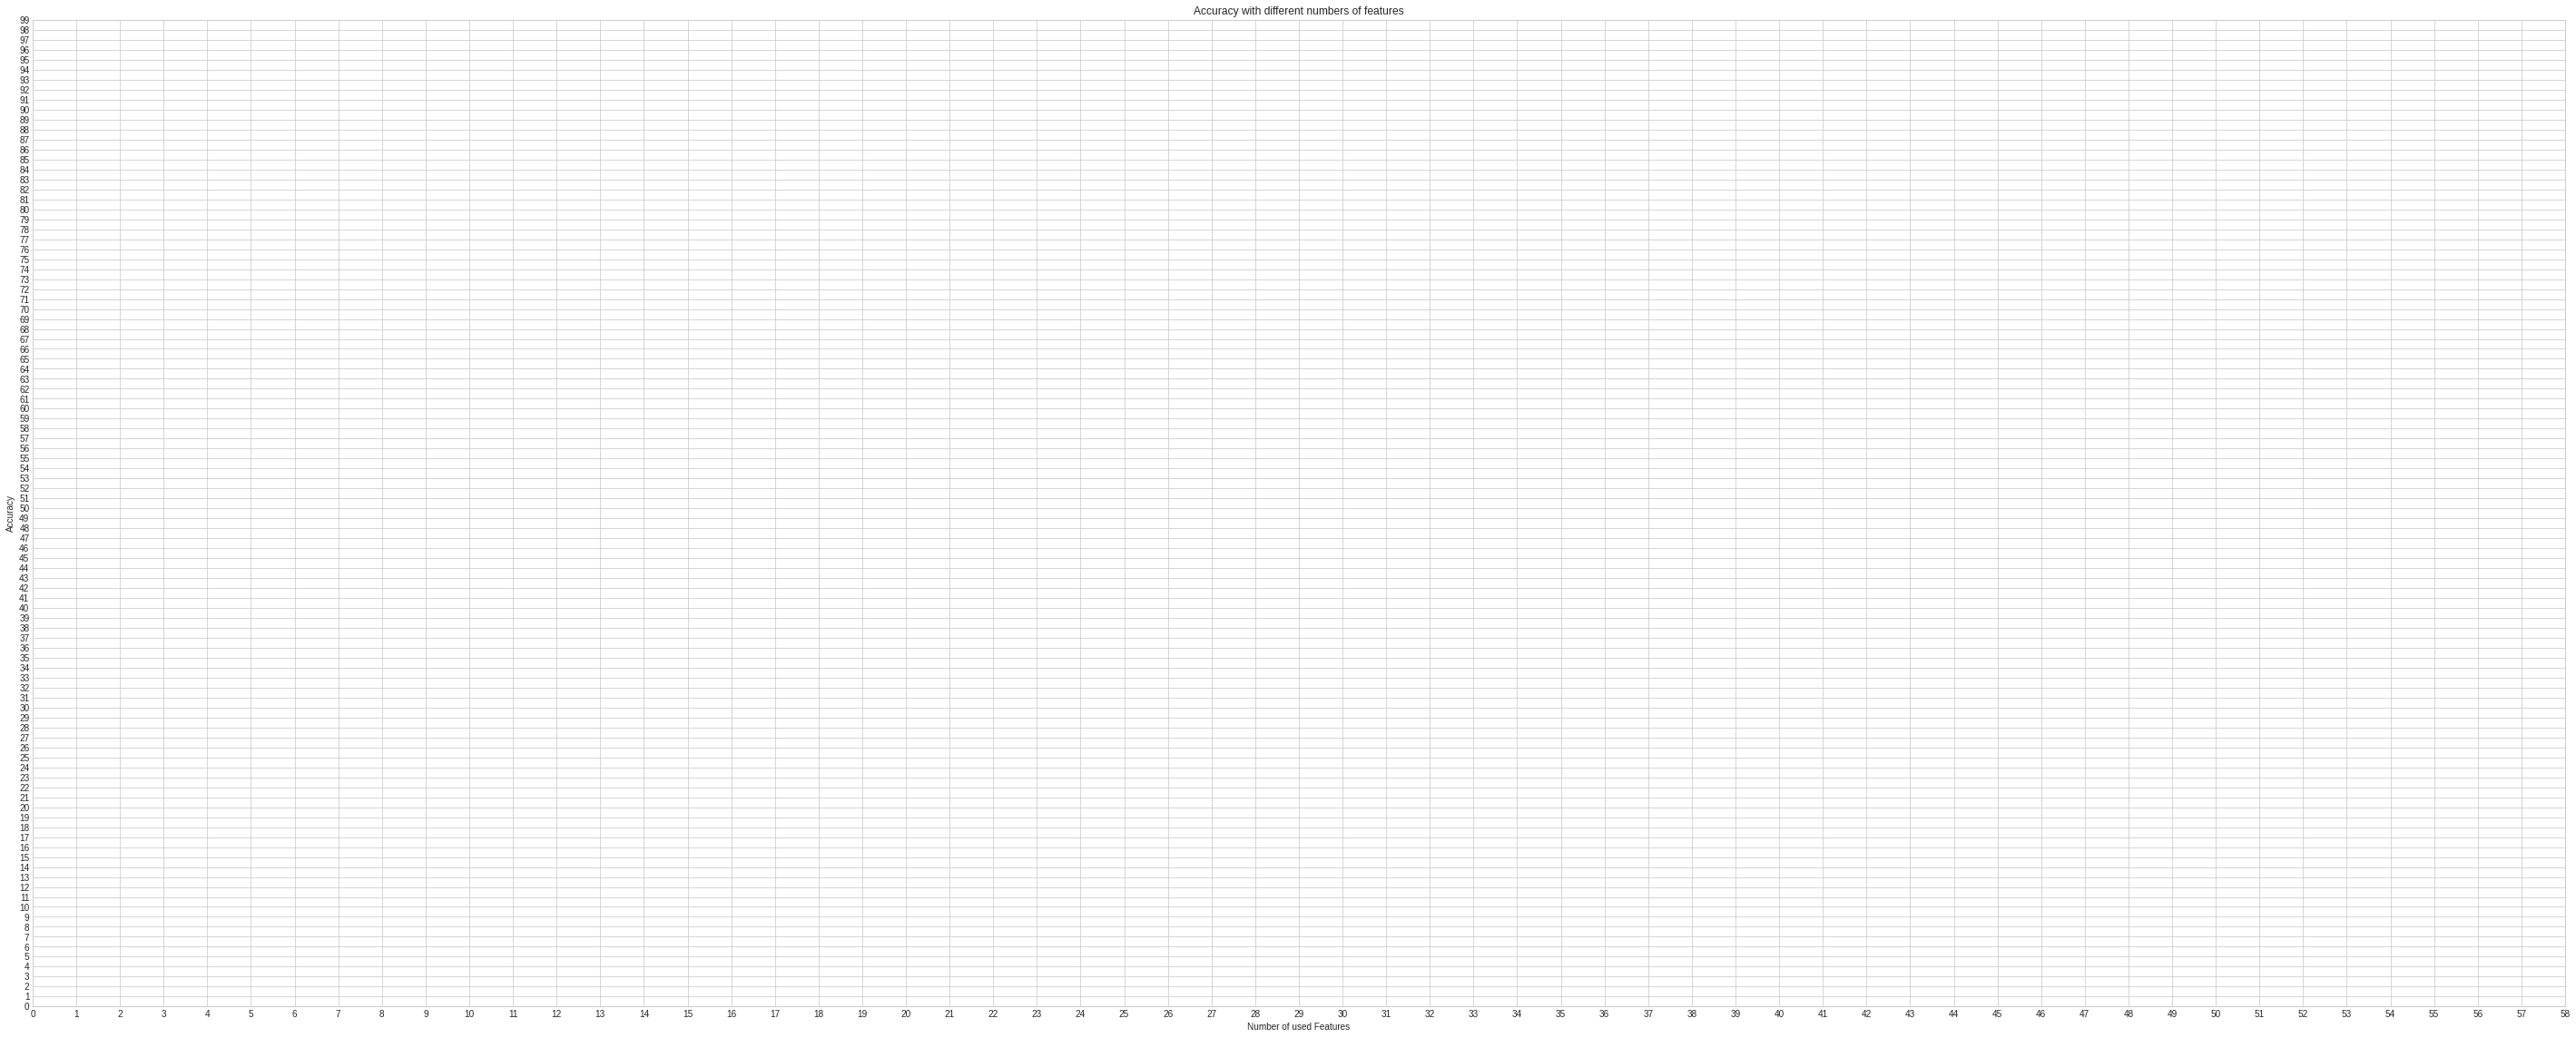

In [22]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(50, 20)
ax.set_title("Accuracy with different numbers of features")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of used Features")
ax.set_xticks(np.arange(0, len(feature_numbers)+1, 1))
ax.set_yticks(np.arange(0, 100, 1))


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# data =  np.concatenate((accuracy_list[0:2], moving_average(accuracy_list, 4)))
ax.plot(feature_numbers,accuracy_list)
ax.bar(feature_numbers,accuracy_list, width=0.3)
# ax.text(1, -15, text, verticalalignment ='center_baseline', fontsize='large' , bbox={'facecolor': 'white', 'pad': 0})
# # plt.plot(feature_numbers, accuracy_list)
for i,j in zip(feature_numbers,accuracy_list):
    ax.annotate(str(j),xy=(i,j))
plt.show()
fig.savefig('accuracy of the model with different number of features on dataset {}.jpg'.format(chosen_dataset_name), dpi=100)
print(np.average(accuracy_list[11:]))

In [ ]:

mean = np.average(importances)
percentile_amount = 50
threshold = np.percentile(importances, percentile_amount)
bool_array = importances > threshold
clipped_importances = importances[bool_array]
clipped_feature_names = feature_names[bool_array]
clipped_std = std[bool_array]
print(len(clipped_importances))
print(len(clipped_std))

forest_importances_clipped = pd.Series(clipped_importances, index=clipped_feature_names)
fig, ax = plt.subplots()
forest_importances_clipped.plot.bar(yerr=clipped_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(50, 25)
fig.savefig('grouped_all_levels_{}_percentile_dataset_{}_feature_importance.jpeg'.format(percentile_amount,
                                                                                         chosen_dataset_name), dpi=100)
fig.tight_layout()

In [ ]:

# clipped_forest_importances = pd.Series(clipped_importances, index=clipped_feature_names)
# fig2, ax2 = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax2)
# ax2.set_title("Feature importances using MDI")
# ax2.set_ylabel("Mean decrease in impurity")
# fig2.set_size_inches(50, 25)
# fig2.savefig('test_importance_18.jpeg', dpi=100)
# fig2.tight_layout()


In [ ]:
# Creating a model (classifier) with train dataset
# self.model_to_name = {"RF": "Random Forest", "DT": "Decision Tree", "MLP": "MLP Classifier",
#                       "KN": "KNeighborsClassifier", "QDA": "QuadraticDiscriminantAnalysis", "NB": "GaussianNB",
#                       "ADA": "AdaBoostClassifier", "svm": "SVM", "sdg": "SGDClassifier"}
data_set_1_classifier = a.generate_with_all(x_dtns_train, y_dtns_train, model_name="RF")
data_set_2_classifier = a.generate_with_all(x_dtns_train, y_dtns_train)

#Comparing the accuracy of model on different dataset
a.compare_two_dataset(dtns_df, dtns_df, model_name="RF")


In [ ]:
# dtns_df.describe()
dtns_df.iloc[:, 14:30].describe()

In [ ]:
# Get the correlation of the data
correlation = dtns_df.corr()
f, axes = plt.subplots(figsize=(40, 20))
#diverging color map generate
cmap = sns.diverging_palette(150, 275, as_cmap=True)

sns.heatmap(correlation, cmap=cmap, center=0, linewidth=1, cbar_kws={"shrink": 0.5})

plt.title('Correlation Matrix Heatmap')

In [ ]:
#Get the columns name in the dataset
dtns_df.columns

In [ ]:
#Cahnge Nans in correlation with false and true, get the name of the columns that have correlation true.
nan_corr = list(correlation.cwnd_rate[~correlation.loc[['cwnd_rate'], :].isna().any()].index.values)


In [ ]:
sns.pairplot(x_vars=nan_corr, y_vars='cwnd_rate', data=dtns_df.loc[dtns_df['label_value'] == 0], height=5)
plt.show()